In [1]:
import importlib
from torch import nn
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
import datetime
from sklearn.metrics import roc_auc_score

import torch
from torchvision import transforms
import pandas as pd
import seaborn as sn
import src.distance_metrics

import src.ood_detection
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import EmpiricalCovariance, GraphicalLasso
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans 
import statsmodels.api as sm 
from scipy import stats
import pandas as pd
import seaborn as sns
from distfit import distfit
from scipy.stats import gamma
import scipy.stats as stats
import src.datasets

import os
from PIL import Image
import h5py
import torch.optim as optim
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any, Sequence
import math

c:\Users\rooben\anaconda3\envs\sanuberto\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
def preprocess_images(input_dir, output_dir):
    with h5py.File(os.path.join(input_dir, '3dshapes.h5'), 'r') as dataset:
        data = dataset['images'][:]  # Assuming this fits into memory; otherwise, process in chunks.
    
    # Resize images (example using OpenCV for batch processing could be faster)
    resized_images = np.array([np.array(Image.fromarray(img).resize((32, 32))) for img in data])

    # Save preprocessed data
    with h5py.File(os.path.join(output_dir, '3dshapes_preprocessed.h5'), 'w') as f:
        f.create_dataset('images', data=resized_images)
#preprocess_images("../data/Fast_3DShapes/raw","../data/Fast_3DShapes/processed")

In [135]:
def denormalize(normalized, basis):
    return basis.min() + (basis.max() - basis.min())*((normalized + 1)/2)

def normalize(unnormalized, basis):
    return (2 * (unnormalized - basis.min()) / (basis.max() - basis.min()) - 1)

def normalize_feat_wise(unnormalized, basis):
    return (2 * (unnormalized - basis.min(0)) / (basis.max(0) - basis.min(0)) - 1)

def denormalize_feat_wise(normalized, basis):
    return basis.min(0) + (basis.max(0) - basis.min(0))*((normalized + 1)/2)

def denormalize_std(normalized, basis):
    return normalized * basis.std(0) + basis.mean(0)

def normalize_std(unnormalized, basis):
    return (unnormalized - basis.mean(0))/basis.std(0)

def feature_normalize(X, axis=1, eps=1e-12):
    """Normalize along axis (rows if axis=1) with numerical stability. From mahalanobis ++"""
    X = np.asarray(X)
    norms = np.linalg.norm(X, ord=2, axis=axis, keepdims=True)
    return X / np.clip(norms, eps, None)



In [27]:
def show_images_grid(
    data,
    filenames: Sequence[str],
    max_cols: int = 10,
    titles: Optional[Sequence[str]] = None,
    figsize_per_cell: float = 2.0,
    turn_off_axes: bool = True,
    save_path: Optional[str] = None,
):
    """
    Display images in a grid with up to `max_cols` columns.

    Args:
        root: Root directory for images (can be "" if `filenames` are absolute).
        filenames: List of image paths (relative to `root`, or absolute paths).
        max_cols: Maximum number of columns in the grid.
        titles: Optional list of titles per image (same length as filenames).
        figsize_per_cell: Size multiplier for each cell in inches.
        turn_off_axes: If True, hides axes.
        save_path: If provided, saves the figure to this path.

    Returns:
        (fig, axes) from matplotlib for further customization.
    """
    
    paths = []
    infos = []
    for name in filenames:
        p = int(name.split("/")[2].split("_")[0])
        infos.append(name.split("/")[2])
        paths.append(p)

    # Load images (RGB), skipping missing ones with a warning
    imgs, kept_paths, kept_titles = [], [], []
    for i, p in enumerate(paths):
        try:
            img = data[p]
            imgs.append(img)
            kept_paths.append(infos[i])
            if titles is not None and i < len(titles):
                kept_titles.append(infos[i])
            else:
                kept_titles.append(None)
        except Exception as e:
            print(f"[warn] Could not load {p}: {e}")

    n = len(imgs)
    if n == 0:
        print("No images to display.")
        return None, None

    cols = min(max_cols, n)
    rows = math.ceil(n / cols)
    fig_w = max(1, cols * figsize_per_cell)
    fig_h = max(1, rows * figsize_per_cell)
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = np.array(axes, dtype=object).reshape(rows, cols)  # handles 1D cases

    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            if idx < n:
                ax.imshow(imgs[idx])
                if turn_off_axes:
                    ax.axis("off")
                if kept_titles[idx]:
                    ax.set_title(str(kept_titles[idx]), fontsize=9)
            else:
                ax.axis("off")
            idx += 1

    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=200)

    plt.show()

    return fig, axes

def split_names_to_dict(name_list, append = False, labels_dict = None ):
    if ~append:
        labels_dict = {"fh":[],"wh":[],"oh":[],"sc":[],"sh":[] ,"or":[] }
    for name in name_list:
        spltted_name = name.split("_")
        labels_dict["fh"].append(int(spltted_name[3][2:]))
        labels_dict["wh"].append(int(spltted_name[4][2:]))
        labels_dict["oh"].append(int(spltted_name[5][2:]))
        labels_dict["sc"].append(int(spltted_name[6][2:]))
        labels_dict["sh"].append(int(spltted_name[7][2:]))
        labels_dict["or"].append(int(spltted_name[8][2:].split(".")[0]))

    return labels_dict

#### Load the data

In [30]:
with h5py.File(os.path.join("./shapes3d", '3dshapes.h5'), 'r') as dataset:
    data = dataset['images'][:]  # Assuming this fits into memory; otherwise, process in chunks.
    

#### Load the activations

In [104]:
epoch = 1
seed = "_s3" #_s2 : hue; s3 : or; s4: fh
shapes_te_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
shapes_te_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val.npy")
shapes_tr_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train_names.npy").flatten()
shapes_tr_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train.npy")




In [ ]:
# get all the labels from image names
tr_labels = split_names_to_dict(shapes_tr_names)


## SAE time


**Definitions of the summary statistics of SAE latents from Lim et al. 2024**

**Sparsity (activated frequency)** represents how frequently this latent is activated. We count the number of images having positive SAE latent activations and divide by the total number of seen images. An SAE latent with a high frequency either represents a common concept or is an uninterpretable (noisy) latent.

**Mean activation value** is computed by averaging the positive activation value among the activated samples. The mean activation value implies the SAE model’s confidence. A latent direction is more likely to represent a meaningful concept if it has a high 
mean activation value.

**Label entropy** measures how many unique labels activate the latent. Precisely, we compute the probability of a label based on its activation value and compute the entropy as
 $$prob_c = \frac{sum_c}{\sum_{c\in C}sum_c},\quad  entropy = − \sum_{c\in C} (prob_c \log prob_c), (2)$$ 
where $sum_c$ is the summed activation values for label c ∈ C. The entropy being equal to zero indicates that all reference images have exactly the same label. Higher entropy indicates that more labels contribute to the latent’s activation.

**Label standard deviation.** In ImageNet, class labels are organized in a hierarchical structure based on WordNet’s semantic relationships [8, 22]. We leverage this label structure and use the label standard deviation of reference images as a clue for the semantic granularity besides the label entropy when exploring the latents.

In [33]:
from src.base_sae import SparseAutoencoder
from src.sae_utils import *

#### Train a SAE

In [137]:
epoch = 1
seed = "_s4" #can be left "" if folder does not exist
normalization_on = True # feature normalized or not
shapes_te_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
shapes_te_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val.npy")
shapes_tr_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train_names.npy").flatten()
shapes_tr_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train.npy")

if normalization_on:
    shapes_tr_acts = feature_normalize(shapes_tr_acts)
    shapes_te_acts = feature_normalize(shapes_te_acts)


tr_labels = split_names_to_dict(shapes_tr_names)
te_labels = split_names_to_dict(shapes_te_names)

latents = torch.tensor(shapes_tr_acts)



In [181]:
# Build and train SAE
expansion_coef = 5
input_dim = 512
epochs = 40

sae = SparseAutoencoder(input_dim=input_dim, code_dim=input_dim*expansion_coef,tied_weights=True)
train_sae(sae, latents, epochs=epochs, l1_lambda=5e-3,verbose_every=5,)

ckpt_file = Path(f"sae_{seed}_{epoch}_SN_reg{str(normalization_on)}.pt")
save_checkpoint(sae, ckpt_file, meta={"epochs": epochs})




Epoch   1/40 | loss 0.000057  l1 0.000023  dead% 32.46  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0388
Epoch   5/40 | loss 0.000006  l1 0.000004  dead% 82.54  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0389
Epoch  10/40 | loss 0.000004  l1 0.000003  dead% 84.65  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0389
Epoch  15/40 | loss 0.000003  l1 0.000002  dead% 86.13  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0389
Epoch  20/40 | loss 0.000003  l1 0.000002  dead% 87.81  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0389
Epoch  25/40 | loss 0.000003  l1 0.000002  dead% 90.08  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0390
Epoch  30/40 | loss 0.000003  l1 0.000002  dead% 92.03  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0390
Epoch  35/40 | loss 0.000003  l1 0.000002  dead% 93.32  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0390
Epoch  40/40 | loss 0.000003  l1 0.000002  dead% 94.38  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0391
Checkpoint saved to sae__s4_1_SN_regTrue.pt


In [37]:

# Save a checkpoint
ckpt_file = Path(f"sae_{seed}_{epoch}_SN_reg.pt")
# Reload model
sae = load_checkpoint(ckpt_file)

# Grab top activations for concept 13


In [184]:

most_specific = rank_concepts(stats, key="label_entropy", ascending=False, top_n=30, return_scores=True)
print("Top 10 most label‑diverse concepts (high entropy):")
for cid, sc in most_specific:
    print(f"  Concept {cid:4d} | entropy = {sc:.3f}")
most_common= rank_concepts(stats, key="sparsity", ascending=False, top_n=10, return_scores=True)
print("Top 10 most common concepts (high sparsity):")
for cid, sc in most_common:
    print(f"  Concept {cid:4d} | sparsity = {sc:.3f}")
most_common= rank_concepts(stats, key="mean_activation", ascending=False, top_n=10, return_scores=True)
print("Top 10 most common concepts (high activation):")
for cid, sc in most_common:
    print(f"  Concept {cid:4d} | mean_activation = {sc:.3f}")
most_common= rank_concepts(stats, key="label_std", ascending=False, top_n=10, return_scores=True)
print("Top 10 most common concepts (high label_std):")
for cid, sc in most_common:
    print(f"  Concept {cid:4d} | std = {sc:.3f}")

Top 10 most label‑diverse concepts (high entropy):
  Concept 1845 | entropy = 1.585
  Concept  198 | entropy = 1.585
  Concept 1252 | entropy = 1.585
  Concept  644 | entropy = 1.585
  Concept 1124 | entropy = 1.585
  Concept  849 | entropy = 1.585
  Concept 1148 | entropy = 1.585
  Concept 2400 | entropy = 1.585
  Concept 1460 | entropy = 1.585
  Concept 2361 | entropy = 1.584
  Concept 1568 | entropy = 1.584
  Concept  788 | entropy = 1.584
  Concept 1772 | entropy = 1.584
  Concept 1652 | entropy = 1.584
  Concept 1833 | entropy = 1.584
  Concept 1986 | entropy = 1.584
  Concept 2042 | entropy = 1.584
  Concept  601 | entropy = 1.584
  Concept 1569 | entropy = 1.584
  Concept  497 | entropy = 1.584
  Concept 1027 | entropy = 1.583
  Concept  111 | entropy = 1.583
  Concept 1314 | entropy = 1.583
  Concept 1573 | entropy = 1.583
  Concept  246 | entropy = 1.583
  Concept 1620 | entropy = 1.583
  Concept   29 | entropy = 1.583
  Concept  754 | entropy = 1.583
  Concept 1635 | entropy 

#### choose specific neuron subsets by sparsity other metrics

In [185]:
criteria = {
    "sparsity":        (None, None),   # upper-bounded
    "label_entropy":   (None,None),    # upper-bounded
    "mean_activation": (None, None ),   # lower-bounded
    "label_std" : (None,None)
}


picked = query_concepts(stats,
                        bounds=criteria,
                        sort_key="label_entropy",  # any metric in the dict
                        ascending=True,            # smallest entropy first
                        return_scores=True)        # → [(id, metric_dict), …]


In [186]:
picked_keys= [i[0] for i in picked]
picked_keys

[552,
 774,
 1024,
 1219,
 1259,
 1328,
 1510,
 1627,
 1761,
 1888,
 1932,
 295,
 1778,
 1659,
 1526,
 129,
 2520,
 1449,
 835,
 2516,
 699,
 2062,
 873,
 1447,
 1764,
 4,
 1223,
 541,
 1556,
 1192,
 279,
 2323,
 1133,
 1416,
 1860,
 226,
 1079,
 1547,
 2154,
 2417,
 1073,
 1581,
 2237,
 2462,
 2374,
 1109,
 1069,
 1675,
 240,
 626,
 1052,
 1354,
 464,
 2002,
 670,
 957,
 2557,
 2251,
 2239,
 1248,
 478,
 1037,
 1271,
 1353,
 2425,
 745,
 2555,
 1453,
 2140,
 2147,
 144,
 202,
 645,
 766,
 875,
 1478,
 11,
 1206,
 1543,
 2423,
 2538,
 917,
 1958,
 803,
 1431,
 236,
 1090,
 1716,
 2171,
 1220,
 2015,
 1747,
 936,
 602,
 2330,
 2370,
 1967,
 1261,
 340,
 632,
 2264,
 2445,
 1654,
 2267,
 706,
 566,
 254,
 1936,
 1757,
 3,
 943,
 958,
 1923,
 2203,
 1306,
 1941,
 2404,
 2539,
 452,
 1929,
 2249,
 1366,
 505,
 417,
 477,
 698,
 2207,
 1268,
 1842,
 1589,
 1072,
 1837,
 947,
 2089,
 1707,
 1784,
 131,
 69,
 1811,
 1810,
 394,
 624,
 2040,
 1273,
 671,
 117,
 1635,
 754,
 29,
 1620,
 246,
 1

#### draw the selection

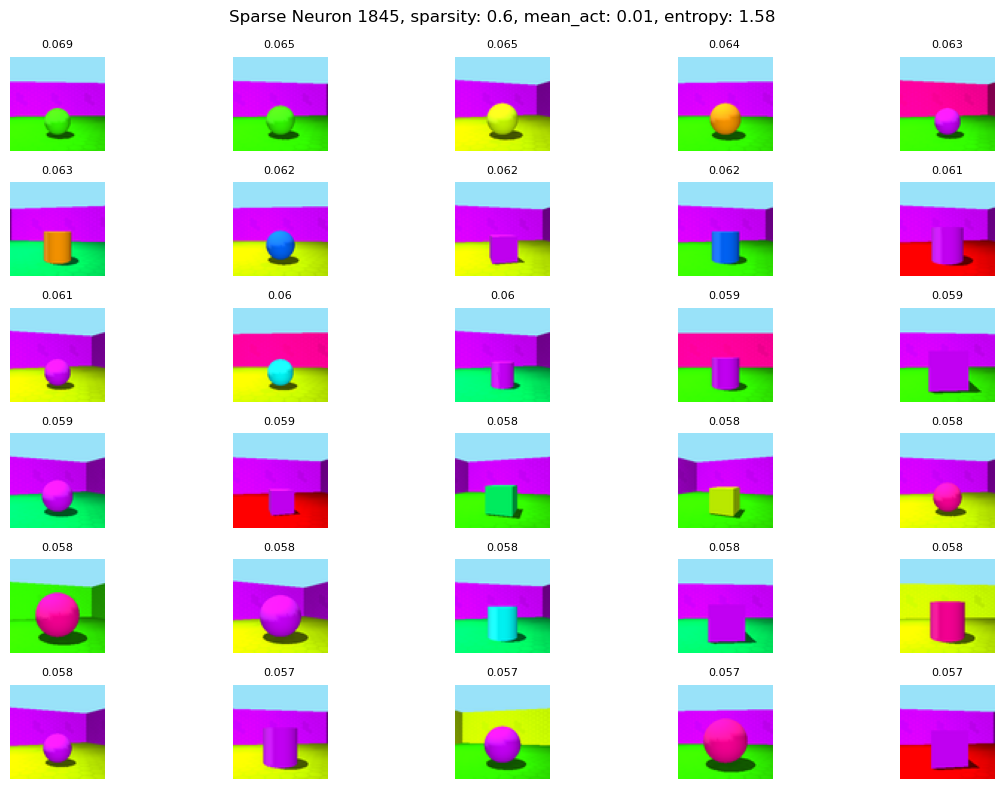

In [189]:
concept = picked_keys[-1]
top_idx, top_act = most_activated_indices(sae, latents, concept, k=30)

plot_top_k_images(shapes_tr_names[top_idx],data,figsize=(12,8),top_act = top_act.detach().numpy(),stats=stats[concept],neuron_nr=concept)

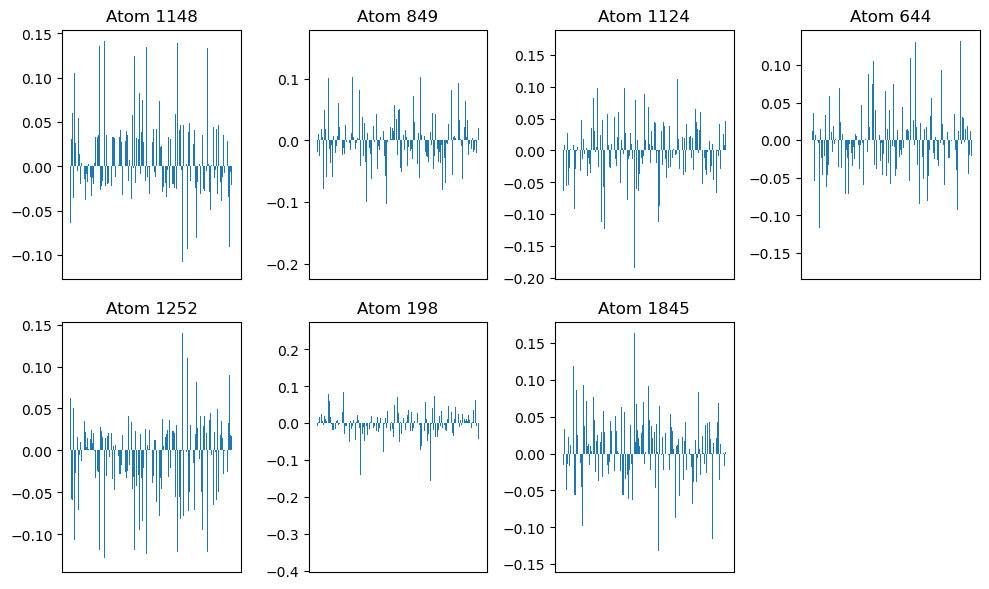

In [190]:
# Visualise dictionary atoms & top images 
atom_indexes = picked_keys[-7:]
plot_dictionary_atoms(sae, num_atoms=len(atom_indexes),atom_indexes_bool=True,atom_indexes=atom_indexes)



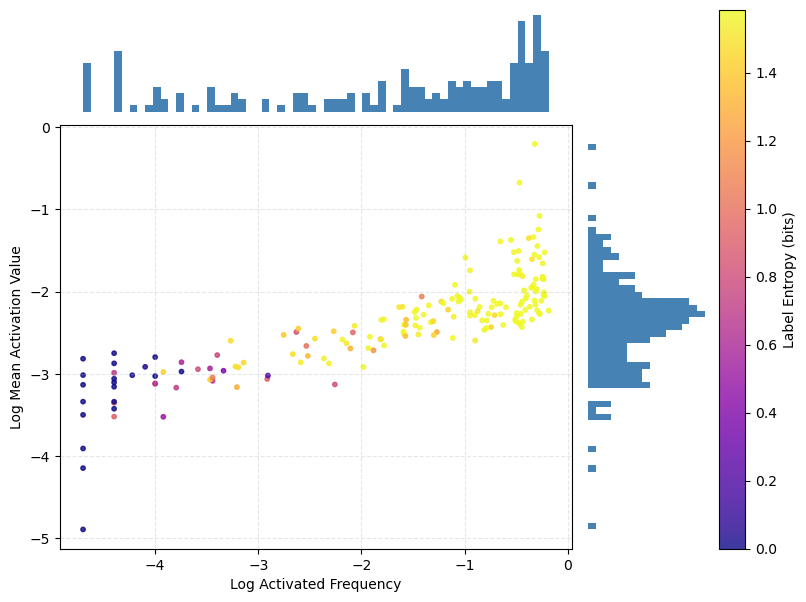

In [191]:
plot_metrics_figure(stats)